In [1]:
from datasets import load_dataset
raw_datasets = load_dataset("Helsinki-NLP/opus-100", "en-id")
raw_datasets

DatasetDict({
    test: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 1000000
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})

In [1]:
model_t5 = "muvazana/flan-t5-base-opus-en-id-id-en"

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_t5)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
def normalize_text(text):
    text = text.lower()  # Lowercase
    # text = re.sub(r"[^\w\s]", "", text)  # Remove non-alphanumeric characters (except whitespace)
    # text = re.sub(r"\s+", " ", text)  # Replace excess whitespace with single space
    return text

prefix = "translate to Indonesia: "
source_lang = "en"
target_lang = "id"
def preprocess_function(data):
   inputs = [prefix + normalize_text(dt[source_lang]) for dt in data["translation"]]
   targets = [normalize_text(dt[target_lang]) for dt in data["translation"]]
   model_inputs = tokenizer(inputs, truncation=True)
   # Setup the tokenizer for targets
   with tokenizer.as_target_tokenizer():
       labels = tokenizer(targets, truncation=True)
   model_inputs["labels"] = labels["input_ids"]
   return model_inputs
tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

c:\Users\IBDA\.conda\envs\ta-jacob\lib\site-packages\transformers\tokenization_utils_base.py:3921: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [5]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(500000))
small_eval_dataset = tokenized_datasets["validation"].shuffle(seed=42)

In [2]:
from transformers import T5ForConditionalGeneration, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
model = T5ForConditionalGeneration.from_pretrained(model_t5)
model = model.cuda()

In [3]:
model

T5ForConditionalGeneration(
  (shared): Embedding(32134, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32134, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo):

In [7]:
# Freeze all layers except the decoder's last layers (adjust as needed)
count = 0
for param in model.get_encoder().parameters():
    param.requires_grad = False
    count+=1

print(f"freezes {count} layers")

freezes 111 layers


In [8]:
args = Seq2SeqTrainingArguments(
   f"flan-t5-base-finetuned-{source_lang}-to-{target_lang}",
   evaluation_strategy = "epoch",
   save_strategy= "epoch",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   weight_decay=0.01,
   save_total_limit=10,
   num_train_epochs=10, 
   predict_with_generate=True,
   load_best_model_at_end= True,
   gradient_accumulation_steps=2,
)

In [9]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [10]:
import numpy as np
import evaluate
metric = evaluate.load("sacrebleu")
meteor = evaluate.load('meteor')

def postprocess_text(preds, labels):
   preds = [pred.strip() for pred in preds]
   labels = [[label.strip()] for label in labels]
   return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels!= -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    meteor_result = meteor.compute(predictions=decoded_preds, references=decoded_labels)
    prediction_lens = [np.count_nonzero(pred!= tokenizer.pad_token_id) for pred in preds]
    result = {'bleu' : result['score']}
    result["gen_len"] = np.mean(prediction_lens)
    result["meteor"] = meteor_result["meteor"]
    result = {k: round(v, 4) for k, v in result.items()}
    return result

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\IBDA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\IBDA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\IBDA\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [11]:
trainer = Seq2SeqTrainer(
   model,
   args,
   train_dataset=small_train_dataset,
   eval_dataset=small_eval_dataset,
   data_collator=data_collator,
   tokenizer=tokenizer,
   compute_metrics=compute_metrics                                                                                                                 
)
trainer.train()

  0%|          | 0/156250 [00:00<?, ?it/s]

{'loss': 2.4549, 'grad_norm': 1.1310398578643799, 'learning_rate': 2.9904e-05, 'epoch': 0.03}
{'loss': 2.2488, 'grad_norm': 1.1083518266677856, 'learning_rate': 2.9808000000000003e-05, 'epoch': 0.06}
{'loss': 2.1754, 'grad_norm': 0.8246461153030396, 'learning_rate': 2.9712e-05, 'epoch': 0.1}
{'loss': 2.1769, 'grad_norm': 0.9260937571525574, 'learning_rate': 2.9616e-05, 'epoch': 0.13}
{'loss': 2.1435, 'grad_norm': 1.0432209968566895, 'learning_rate': 2.9520000000000002e-05, 'epoch': 0.16}
{'loss': 2.1402, 'grad_norm': 0.8702430129051208, 'learning_rate': 2.9424e-05, 'epoch': 0.19}
{'loss': 2.1034, 'grad_norm': 1.0211282968521118, 'learning_rate': 2.9328e-05, 'epoch': 0.22}
{'loss': 2.136, 'grad_norm': 1.281098484992981, 'learning_rate': 2.9232e-05, 'epoch': 0.26}
{'loss': 2.0715, 'grad_norm': 0.8594210743904114, 'learning_rate': 2.9136e-05, 'epoch': 0.29}
{'loss': 2.0763, 'grad_norm': 1.1602412462234497, 'learning_rate': 2.904e-05, 'epoch': 0.32}
{'loss': 2.0613, 'grad_norm': 0.98473280

c:\Users\IBDA\.conda\envs\ta-jacob\lib\site-packages\transformers\generation\utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.8858401775360107, 'eval_bleu': 27.3563, 'eval_gen_len': 9.9795, 'eval_meteor': 0.5302, 'eval_runtime': 42.4156, 'eval_samples_per_second': 47.152, 'eval_steps_per_second': 2.947, 'epoch': 1.0}
{'loss': 1.953, 'grad_norm': 1.0595709085464478, 'learning_rate': 2.6928e-05, 'epoch': 1.02}
{'loss': 1.9738, 'grad_norm': 1.160923719406128, 'learning_rate': 2.6832e-05, 'epoch': 1.06}
{'loss': 1.9876, 'grad_norm': 0.8385946750640869, 'learning_rate': 2.6736e-05, 'epoch': 1.09}
{'loss': 1.9811, 'grad_norm': 0.8609998822212219, 'learning_rate': 2.6640000000000002e-05, 'epoch': 1.12}
{'loss': 1.9718, 'grad_norm': 1.1049467325210571, 'learning_rate': 2.6544000000000002e-05, 'epoch': 1.15}
{'loss': 1.9594, 'grad_norm': 0.8468731641769409, 'learning_rate': 2.6448e-05, 'epoch': 1.18}
{'loss': 1.9709, 'grad_norm': 0.9713853597640991, 'learning_rate': 2.6351999999999998e-05, 'epoch': 1.22}
{'loss': 1.9754, 'grad_norm': 0.8487265706062317, 'learning_rate': 2.6256e-05, 'epoch': 1.25}
{'los

c:\Users\IBDA\.conda\envs\ta-jacob\lib\site-packages\transformers\generation\utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.8464223146438599, 'eval_bleu': 27.4142, 'eval_gen_len': 9.948, 'eval_meteor': 0.5322, 'eval_runtime': 42.2696, 'eval_samples_per_second': 47.315, 'eval_steps_per_second': 2.957, 'epoch': 2.0}
{'loss': 1.9311, 'grad_norm': 0.848031759262085, 'learning_rate': 2.3952e-05, 'epoch': 2.02}
{'loss': 1.933, 'grad_norm': 1.025795817375183, 'learning_rate': 2.3856e-05, 'epoch': 2.05}
{'loss': 1.9163, 'grad_norm': 0.7403720021247864, 'learning_rate': 2.3760000000000003e-05, 'epoch': 2.08}
{'loss': 1.8915, 'grad_norm': 0.7506653666496277, 'learning_rate': 2.3664e-05, 'epoch': 2.11}
{'loss': 1.9246, 'grad_norm': 0.8361743092536926, 'learning_rate': 2.3568e-05, 'epoch': 2.14}
{'loss': 1.9178, 'grad_norm': 0.7932212948799133, 'learning_rate': 2.3472e-05, 'epoch': 2.18}
{'loss': 1.9058, 'grad_norm': 0.7185541987419128, 'learning_rate': 2.3376e-05, 'epoch': 2.21}
{'loss': 1.9286, 'grad_norm': 0.8091328740119934, 'learning_rate': 2.328e-05, 'epoch': 2.24}
{'loss': 1.8998, 'grad_norm': 1.

c:\Users\IBDA\.conda\envs\ta-jacob\lib\site-packages\transformers\generation\utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.8245317935943604, 'eval_bleu': 27.4755, 'eval_gen_len': 9.9435, 'eval_meteor': 0.533, 'eval_runtime': 41.4104, 'eval_samples_per_second': 48.297, 'eval_steps_per_second': 3.019, 'epoch': 3.0}
{'loss': 1.8969, 'grad_norm': 0.9965289831161499, 'learning_rate': 2.0976e-05, 'epoch': 3.01}
{'loss': 1.8527, 'grad_norm': 1.1712647676467896, 'learning_rate': 2.088e-05, 'epoch': 3.04}
{'loss': 1.8787, 'grad_norm': 0.9882304072380066, 'learning_rate': 2.0784e-05, 'epoch': 3.07}
{'loss': 1.8802, 'grad_norm': 1.1834279298782349, 'learning_rate': 2.0688e-05, 'epoch': 3.1}
{'loss': 1.87, 'grad_norm': 0.9025532603263855, 'learning_rate': 2.0592000000000002e-05, 'epoch': 3.14}
{'loss': 1.8903, 'grad_norm': 0.8999606966972351, 'learning_rate': 2.0496e-05, 'epoch': 3.17}
{'loss': 1.8835, 'grad_norm': 0.7726925015449524, 'learning_rate': 2.04e-05, 'epoch': 3.2}
{'loss': 1.8915, 'grad_norm': 0.9964653253555298, 'learning_rate': 2.0304e-05, 'epoch': 3.23}
{'loss': 1.8684, 'grad_norm': 0.726

c:\Users\IBDA\.conda\envs\ta-jacob\lib\site-packages\transformers\generation\utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.8095519542694092, 'eval_bleu': 27.5767, 'eval_gen_len': 9.9185, 'eval_meteor': 0.5327, 'eval_runtime': 42.0275, 'eval_samples_per_second': 47.588, 'eval_steps_per_second': 2.974, 'epoch': 4.0}
{'loss': 1.8454, 'grad_norm': 1.319183349609375, 'learning_rate': 1.7904e-05, 'epoch': 4.03}
{'loss': 1.8569, 'grad_norm': 0.7800212502479553, 'learning_rate': 1.7808e-05, 'epoch': 4.06}
{'loss': 1.8553, 'grad_norm': 0.6935482621192932, 'learning_rate': 1.7712000000000003e-05, 'epoch': 4.1}
{'loss': 1.8496, 'grad_norm': 0.8049852848052979, 'learning_rate': 1.7616000000000002e-05, 'epoch': 4.13}
{'loss': 1.8487, 'grad_norm': 0.948793351650238, 'learning_rate': 1.7519999999999998e-05, 'epoch': 4.16}
{'loss': 1.8964, 'grad_norm': 0.8121398091316223, 'learning_rate': 1.7424e-05, 'epoch': 4.19}
{'loss': 1.8529, 'grad_norm': 0.8409463763237, 'learning_rate': 1.7328e-05, 'epoch': 4.22}
{'loss': 1.8631, 'grad_norm': 0.9141714572906494, 'learning_rate': 1.7232e-05, 'epoch': 4.26}
{'loss': 

c:\Users\IBDA\.conda\envs\ta-jacob\lib\site-packages\transformers\generation\utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.7991516590118408, 'eval_bleu': 27.623, 'eval_gen_len': 9.9295, 'eval_meteor': 0.5331, 'eval_runtime': 43.998, 'eval_samples_per_second': 45.457, 'eval_steps_per_second': 2.841, 'epoch': 5.0}
{'loss': 1.8619, 'grad_norm': 0.9209056496620178, 'learning_rate': 1.4928e-05, 'epoch': 5.02}
{'loss': 1.8405, 'grad_norm': 0.7378142476081848, 'learning_rate': 1.4832000000000001e-05, 'epoch': 5.06}
{'loss': 1.8556, 'grad_norm': 0.8596085906028748, 'learning_rate': 1.4736000000000001e-05, 'epoch': 5.09}
{'loss': 1.8648, 'grad_norm': 1.0325171947479248, 'learning_rate': 1.464e-05, 'epoch': 5.12}
{'loss': 1.8372, 'grad_norm': 0.8716751933097839, 'learning_rate': 1.4544e-05, 'epoch': 5.15}
{'loss': 1.8597, 'grad_norm': 1.269997000694275, 'learning_rate': 1.4448e-05, 'epoch': 5.18}
{'loss': 1.8161, 'grad_norm': 1.0304938554763794, 'learning_rate': 1.4352e-05, 'epoch': 5.22}
{'loss': 1.8403, 'grad_norm': 0.9819675087928772, 'learning_rate': 1.4256e-05, 'epoch': 5.25}
{'loss': 1.8139, 'g

c:\Users\IBDA\.conda\envs\ta-jacob\lib\site-packages\transformers\generation\utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.7907742261886597, 'eval_bleu': 27.6541, 'eval_gen_len': 9.923, 'eval_meteor': 0.5344, 'eval_runtime': 41.0393, 'eval_samples_per_second': 48.734, 'eval_steps_per_second': 3.046, 'epoch': 6.0}
{'loss': 1.8146, 'grad_norm': 0.8514174818992615, 'learning_rate': 1.1952e-05, 'epoch': 6.02}
{'loss': 1.8473, 'grad_norm': 1.1411563158035278, 'learning_rate': 1.1856e-05, 'epoch': 6.05}
{'loss': 1.828, 'grad_norm': 1.0184828042984009, 'learning_rate': 1.1760000000000001e-05, 'epoch': 6.08}
{'loss': 1.8109, 'grad_norm': 0.8139066696166992, 'learning_rate': 1.1664e-05, 'epoch': 6.11}
{'loss': 1.8187, 'grad_norm': 0.9205781817436218, 'learning_rate': 1.1568e-05, 'epoch': 6.14}
{'loss': 1.8219, 'grad_norm': 0.8260648846626282, 'learning_rate': 1.1472000000000001e-05, 'epoch': 6.18}
{'loss': 1.7949, 'grad_norm': 0.9213994145393372, 'learning_rate': 1.1376e-05, 'epoch': 6.21}
{'loss': 1.8546, 'grad_norm': 0.8212313055992126, 'learning_rate': 1.128e-05, 'epoch': 6.24}
{'loss': 1.8155, '

c:\Users\IBDA\.conda\envs\ta-jacob\lib\site-packages\transformers\generation\utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.7850162982940674, 'eval_bleu': 27.5871, 'eval_gen_len': 9.922, 'eval_meteor': 0.5333, 'eval_runtime': 40.9553, 'eval_samples_per_second': 48.834, 'eval_steps_per_second': 3.052, 'epoch': 7.0}
{'loss': 1.8156, 'grad_norm': 0.6921107769012451, 'learning_rate': 8.976e-06, 'epoch': 7.01}
{'loss': 1.8391, 'grad_norm': 0.8845078349113464, 'learning_rate': 8.88e-06, 'epoch': 7.04}
{'loss': 1.7958, 'grad_norm': 0.8952480554580688, 'learning_rate': 8.784000000000001e-06, 'epoch': 7.07}
{'loss': 1.856, 'grad_norm': 1.0162373781204224, 'learning_rate': 8.688e-06, 'epoch': 7.1}
{'loss': 1.8034, 'grad_norm': 0.7884867787361145, 'learning_rate': 8.592e-06, 'epoch': 7.14}
{'loss': 1.8043, 'grad_norm': 0.7297734618186951, 'learning_rate': 8.496e-06, 'epoch': 7.17}
{'loss': 1.7955, 'grad_norm': 2.1291000843048096, 'learning_rate': 8.400000000000001e-06, 'epoch': 7.2}
{'loss': 1.8187, 'grad_norm': 0.9097398519515991, 'learning_rate': 8.304e-06, 'epoch': 7.23}
{'loss': 1.8036, 'grad_norm'

c:\Users\IBDA\.conda\envs\ta-jacob\lib\site-packages\transformers\generation\utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.7816345691680908, 'eval_bleu': 27.5683, 'eval_gen_len': 9.92, 'eval_meteor': 0.5334, 'eval_runtime': 40.7532, 'eval_samples_per_second': 49.076, 'eval_steps_per_second': 3.067, 'epoch': 8.0}
{'loss': 1.8106, 'grad_norm': 1.1677746772766113, 'learning_rate': 5.9040000000000006e-06, 'epoch': 8.03}
{'loss': 1.82, 'grad_norm': 0.910309374332428, 'learning_rate': 5.808e-06, 'epoch': 8.06}
{'loss': 1.803, 'grad_norm': 0.8178417682647705, 'learning_rate': 5.7120000000000005e-06, 'epoch': 8.1}
{'loss': 1.8204, 'grad_norm': 0.8513525724411011, 'learning_rate': 5.616e-06, 'epoch': 8.13}
{'loss': 1.8135, 'grad_norm': 0.8154228925704956, 'learning_rate': 5.52e-06, 'epoch': 8.16}
{'loss': 1.8056, 'grad_norm': 0.690936803817749, 'learning_rate': 5.424e-06, 'epoch': 8.19}
{'loss': 1.8249, 'grad_norm': 0.6415383815765381, 'learning_rate': 5.3280000000000005e-06, 'epoch': 8.22}
{'loss': 1.8166, 'grad_norm': 1.2127318382263184, 'learning_rate': 5.232e-06, 'epoch': 8.26}
{'loss': 1.8368, 

c:\Users\IBDA\.conda\envs\ta-jacob\lib\site-packages\transformers\generation\utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.7797763347625732, 'eval_bleu': 27.6195, 'eval_gen_len': 9.9175, 'eval_meteor': 0.5338, 'eval_runtime': 40.8225, 'eval_samples_per_second': 48.993, 'eval_steps_per_second': 3.062, 'epoch': 9.0}
{'loss': 1.8305, 'grad_norm': 1.1208795309066772, 'learning_rate': 2.928e-06, 'epoch': 9.02}
{'loss': 1.7916, 'grad_norm': 1.0634257793426514, 'learning_rate': 2.832e-06, 'epoch': 9.06}
{'loss': 1.8182, 'grad_norm': 0.9172326922416687, 'learning_rate': 2.736e-06, 'epoch': 9.09}
{'loss': 1.8042, 'grad_norm': 1.0225638151168823, 'learning_rate': 2.6399999999999997e-06, 'epoch': 9.12}
{'loss': 1.8106, 'grad_norm': 1.1463745832443237, 'learning_rate': 2.544e-06, 'epoch': 9.15}
{'loss': 1.7989, 'grad_norm': 0.8622368574142456, 'learning_rate': 2.448e-06, 'epoch': 9.18}
{'loss': 1.769, 'grad_norm': 0.9318895936012268, 'learning_rate': 2.352e-06, 'epoch': 9.22}
{'loss': 1.8086, 'grad_norm': 0.9807505011558533, 'learning_rate': 2.256e-06, 'epoch': 9.25}
{'loss': 1.7955, 'grad_norm': 0.813

c:\Users\IBDA\.conda\envs\ta-jacob\lib\site-packages\transformers\generation\utils.py:1141: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.779430866241455, 'eval_bleu': 27.6262, 'eval_gen_len': 9.9235, 'eval_meteor': 0.534, 'eval_runtime': 41.2779, 'eval_samples_per_second': 48.452, 'eval_steps_per_second': 3.028, 'epoch': 10.0}


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


{'train_runtime': 27214.609, 'train_samples_per_second': 183.725, 'train_steps_per_second': 5.741, 'train_loss': 1.87735044765625, 'epoch': 10.0}


TrainOutput(global_step=156250, training_loss=1.87735044765625, metrics={'train_runtime': 27214.609, 'train_samples_per_second': 183.725, 'train_steps_per_second': 5.741, 'total_flos': 2.3667186282518938e+17, 'train_loss': 1.87735044765625, 'epoch': 10.0})

In [12]:
trainer.save_model('model/flan-t5-finetuned-en-to-id')

In [13]:
import pandas as pd
log_history = pd.DataFrame(trainer.state.log_history)
bleu_log = log_history["eval_bleu"].dropna().to_list()
meteor_log = log_history["eval_meteor"].dropna().to_list()
eval_log = log_history["eval_loss"].dropna().to_list()

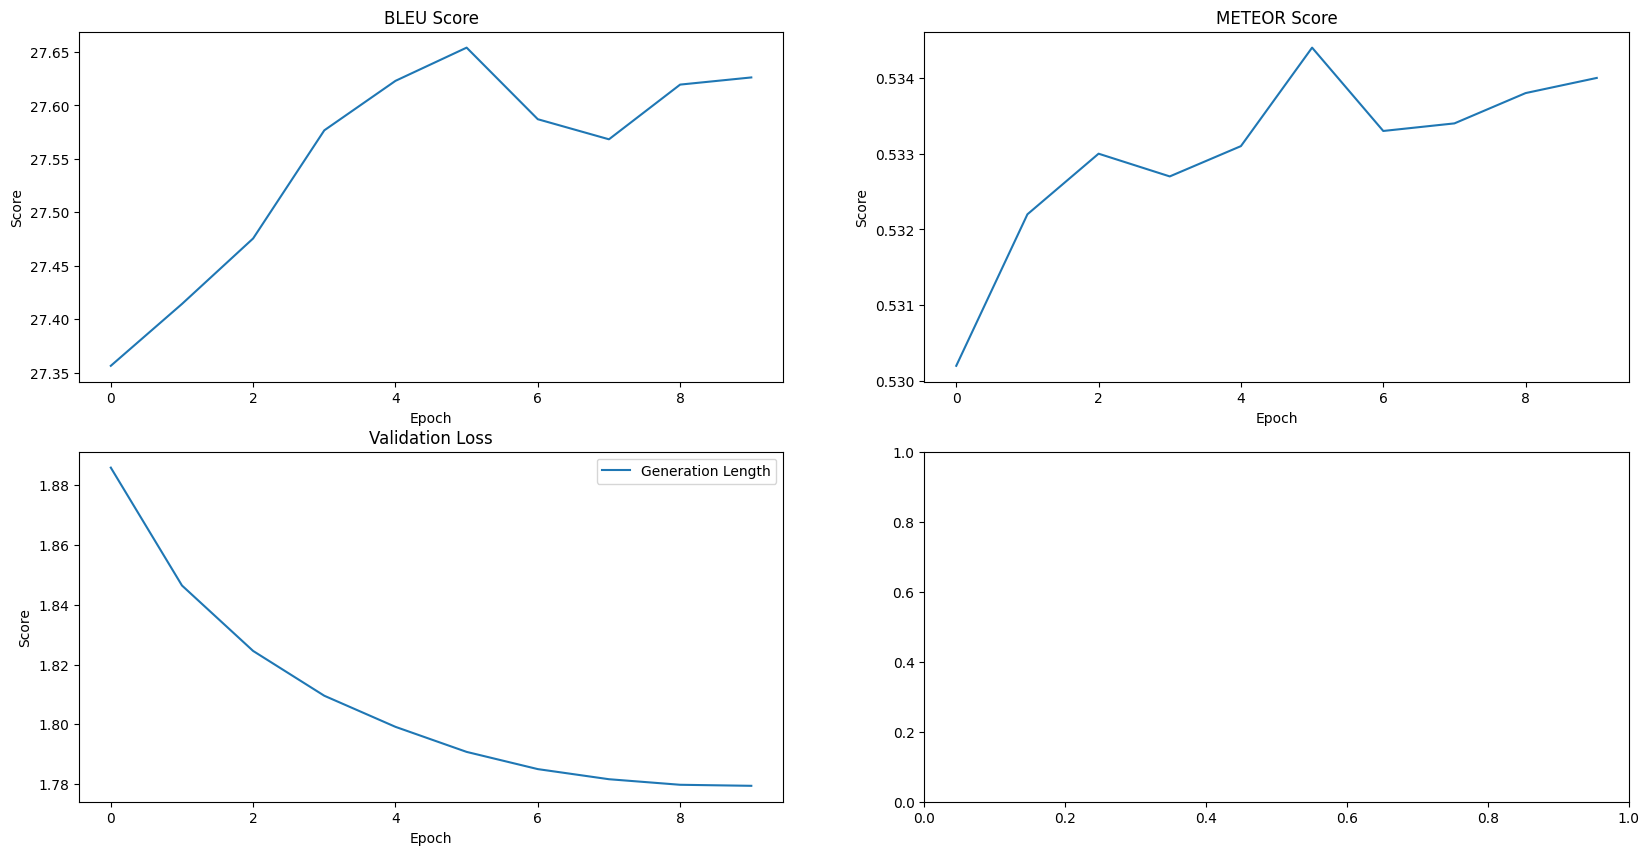

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(20,10))
plt.subplot(2, 2, 1)
plt.plot(range(len(bleu_log)), bleu_log, label='BLEU Score')
plt.title("BLEU Score")
plt.xlabel('Epoch')
plt.ylabel('Score')

plt.subplot(2, 2, 2)
plt.plot(range(len(meteor_log)), meteor_log, label='METEOR Score')
plt.title("METEOR Score")
plt.xlabel('Epoch')
plt.ylabel('Score')

plt.subplot(2, 2, 3)
plt.plot(range(len(eval_log)), eval_log, label='Generation Length')
plt.title("Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Score')

plt.legend()
plt.show()

In [15]:
import csv
rows = []
for i in range(len(bleu_log)):
    row = {
        'Epoch': i+1,
        'BLEU': bleu_log[i],
        'METEOR': meteor_log[i],
        'validation_loss': eval_log[i],
    }
    rows.append(row)

# Define the fieldnames for the CSV file
fieldnames = ['Epoch', 'BLEU', 'METEOR', 'validation_loss']

# Write the rows to a CSV file
with open('T5.csv', 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for row in rows:
        writer.writerow(row)